# Домашнее задание 4. Конструирование текстовых признаков из твитов пользователей

## Сбор данных

In [1]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer

import nltk

import os
import json
import re

Первый этап - сбор твитов пользователей. Необходимо подключаться к Twitter API и запрашивать твиты по id пользователя. 
Подключение к API подробно описано в ДЗ 1.

In [2]:
import twitter

CONSUMER_KEY = "pEeYvgCsR5cOnxu0LXgNEbSbh"
CONSUMER_SECRET = "XTVthLigui9TioOkINuW28wBHJ8XVtAJVrmOKZZXqR91BUzES3"

ACCESS_TOKEN_KEY = "159127782-PeTXoGSz4xJBzYBJ2x3M5rIGuLXV8fOJ6cQgmHBS"
ACCESS_TOKEN_SECRET = "tW5BG5ktDzFlkz921eFKR95zre21oR9nvIyTKSWDE5yYm"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Для получения твитов пользователя может быть использован метод GetUserTimeline из библиотеки python-twitter. Он позволяет получить не более 200 твитов пользователя. По каждому пользователю достаточно собрать 200 твитов.

Метод имеет ограничение по количеству запросов в секунду. Для получения информации о промежутке времени, которое необходимо подождать для повторного обращения к API может быть использован метод `GetSleepTime`. Для получения информации об ограничениях запросов с помощью метода `GetUserTimeLine` необходимо вызывать `GetSleepTime` с параметром "statuses/user_timeline".

Метод GetUserTimeline возвращает объекты типа Status. У этих объектов есть метод AsDict, который позволяет представить твит в виде словаря.

Id пользователей необходимо считать из файла, как было сделано в ДЗ 1.

Необходимо реализовать функцию `get_user_tweets(user_id)`. Входной параметр - id пользователя из файла. Возвращаемое значение - массив твитов пользователя, где каждый твит представлен в виде словаря. Предполагается, что информация о пользователе содержится в твитах, которые пользователь написал сам. Это означает, что можно попробовать отфильтровать ответы другим пользователям, ссылки и ретвиты, а так же картинки и видео, так как наша цель - найти текстовую информацию.

Дабы обезопасить себя от проблем с интернетом, при скачивании все твитты будем сохранять в отдельный каталог.

In [3]:
catalog = "downloaded_tweets"
if not os.path.exists(catalog):
    os.makedirs(catalog)


def get_user_tweets(user_id):
    """returns list of tweets as dicts"""
    # your code here
    user_tweets = []

    user_tweets = download_user_tweets(user_id)
    filter_user_tweets = [tweet_filter(tweet) for tweet in user_tweets]
    
    return [tweet for tweet in filter_user_tweets if tweet["text"] != ""]

def tweet_filter(tweet):
    """cleen all tweets from garbage"""
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet["text"])
    
    nicknames = re.findall('@(?:[a-zA-Z]|[0-9]|[_])+', tweet["text"])
    
    # Удалим все хэштеги
    hstgs = []
    if "hashtags" in tweet:
        for hstg in tweet["hashtags"]:
            if 'text' in hstg:
                hstgs.append("#"+hstg['text'])
    
    delete_list = []
    delete_list.extend(urls)
    delete_list.extend(nicknames)
    delete_list.extend(hstgs)
    
    for del_obj in delete_list:
        tweet["text"]=tweet["text"].replace(del_obj, "")
    
    # Удалим текст, если есть фото или видео файл    
    if "media" in tweet: tweet["text"] = ""
        
    return tweet

def save_in_file(user_tweets,file_name):
    f = open(file_name, 'a')        
    for tweet in user_tweets:
        # нам незачем хранить всю информацию о пользователе
        tweet["user"] = tweet["user"]["id"] 
        f.write(json.dumps(tweet)+'\n')
    f.close()

def download_user_tweets(user_id):
    """download a list of tweets from a file, if it exists, or from the internet"""
    global catalog
    file_name = catalog + '/' + str(user_id)
    user_tweets = []
    
    if os.path.exists(file_name):
        with open(file_name) as f:
            for line in f:
                try:
                    user_tweets.append(json.loads(line))
                except:
                    continue
    else:
        try:
            user_tweets = [tweet.AsDict() for tweet in api.GetUserTimeline(user_id = user_id, 
                                                                           count = 200, 
                                                                           exclude_replies = True, 
                                                                           include_rts = False)]
            save_in_file(user_tweets,file_name)
        except twitter.TwitterError, e: 
            t = e.args[0]
            print "Error ocured user {0}: {1}".format(user_id, t)
        
    return user_tweets
       
#a = get_user_tweets(25073877)
#print a

## Разбор текста твита

Обработка текста предполагает разбиение текста на отдельные элементы - параграфы, предложения, слова. Мы будем преобразовывать текст твита к словам. Для этого текст необходимо разбить на слова. Сделать это можно, например, с помощью регулярного выражения.

Необходимо реализовать функцию, `get_words(text)`. Входной параметр - строка с текстом. Возвращаемое значение - массив строк (слов). Обратите внимание, что нужно учесть возможное наличие пунктуации и выделить по возможности только слова. 

In [4]:
def get_words(text):
    """returns list of words"""
    words = []
    blocks = [block for block in text.split(" ") if block != ''] 
    for block in blocks:
        words.append("".join(re.findall('[a-zA-Z]', block)))
    return words

In [5]:
print get_words("Here are:)      #different, New-York %words!")

['Here', 'are', 'different', 'NewYork', 'words']


Далее полученные слова необходимо привести к нормальной форме. То есть привести их к форме единственного числа настоящего времени и пр. Сделать это можно с помощью библиотеки nltk. Информацию по загрузке, установке библиотеки и примерах использования можно найти на сайте http://www.nltk.org/

Для загрузки всех необходимых словарей можно воспользоваться методом download из библиотеки nltk.

In [6]:
import nltk
#nltk.download()

Для дальнейшей обработки слова должны быть приведены к нижнему регистру. 

Для приведения к нормальной форме можно использовать `WordNetLemmatizer` из библиотеки nltk. У этого класса есть метод `lemmatize`.

Также необходимо убрать из текста так называемые стоп-слова. Это часто используемые слова, не несущие смысловой нагрузки для наших задач. Сделать это можно с помощью `stopwords` из nltk.corpus

Необходимо реализовать функцию `get_tokens(words)`. Входной параметр - массив слов. Возвращаемое значение - массив токенов.

In [7]:
from nltk.corpus import stopwords

def get_tokens(words):
    """returns list of tokens"""
    # your code here
    stops = set(stopwords.words('english'))
    new_words = []
    for word in words:
        word = nltk.stem.WordNetLemmatizer().lemmatize(word.lower())
        if word not in stops and len(word) > 1:
            new_words.append(word)
    return new_words

In [8]:
print get_tokens(['Here', 'aRe', "different", 'NewYork', 'words', 'our'])

['different', 'newyork', u'word']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [9]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

Необходимо реализовать функцию `collect_users_tokens()`. Функция должна сконструировать матрицу признаков пользователей. В этой матрице строка - пользователь. Столбец - токен. На пересечении - сколько раз токен встречается у пользователя.
Для построения матрицы можно использовать `DictVectorizer` из `sklearn.feature_extraction`.

In [10]:
from collections import defaultdict

def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    users = [] 
    users_tokens = [] 
    check_point_counter = len(df_users)/10
    counter = 0
    for user in df_users["uid"]:
        tokens = [] 
        tweets = get_user_tweets(user)
        for tweet in tweets:
            token = get_tweet_tokens(tweet["text"])
            if len(token) > 0: tokens.append(token)
        
        record = defaultdict(int)
        for tweet in tokens:
            for word in tweet:
                record[word]+=1
                
        if record:
            users_tokens.append(dict(record))
            users.append(user)
        
        counter += 1
        if counter % check_point_counter == 0: 
            print "{0} treated users in {1}".format(counter,len(df_users))
    
    return users, users_tokens

#len(collect_users_tokens({"uid":[25073877]})[1][0])

In [11]:
TRAINING_SET_URL = "train.csv"
EXAMPLE_SET_URL = "test_submition.csv"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])

users, users_tokens = collect_users_tokens(df_users)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

1194 treated users in 11947
2388 treated users in 11947
3582 treated users in 11947
4776 treated users in 11947
5970 treated users in 11947
7164 treated users in 11947
8358 treated users in 11947
9552 treated users in 11947
10746 treated users in 11947
11940 treated users in 11947


Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [12]:
import numpy as np
np.savez("files/out_4.dat", data=vs, users=users, users_tokens=users_tokens )

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

Нет смысла использовать абсолютно все слова в построении облака. Используем для этого только 200 наиболее используемых слов.

Для начала составитм строку из top-N слов наиболее популярных у наших пользователей с сохранением частоты встречаемости слова.

In [13]:
def create_top_N_words_string(user_tokens, N = 100):
    """Create string of top-N words by their frequency"""
    string = ""
    words = defaultdict(int)
    for tokens in users_tokens:
        for token in tokens:
            words[token] += tokens[token]
            
    words_list = sorted(words.items(), key=lambda x: x[1], reverse=True)
    top_words = [(key[0], key[1]/words_list[N][1]) for key in words_list[0:N]]

    for word_tuple in top_words:
        for w in xrange(word_tuple[1]):
            string += word_tuple[0] + " "
    return string

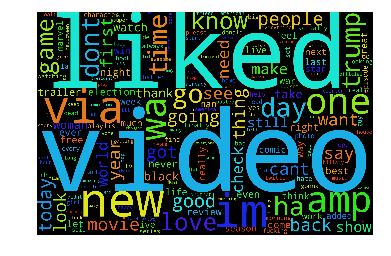

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def draw_tag_cloud(users_tokens):
    """Draws tag cloud of found tokens"""
    string = create_top_N_words_string(users_tokens, 200) 
    wordcloud = WordCloud(
                      font_path=None,
                      stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2000
                     ).generate(string)
    
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.savefig('wordcloud.png', dpi=800)
    plt.show()
    return

draw_tag_cloud(users_tokens)